# Exploring the Embedding and Attention of The-Jam-Machine

## Imports

In [1]:
import matplotlib.pyplot as plt
import random
import torch
import numpy as np
import pandas as pd
import os
from sklearn.manifold import TSNE
from transformers import PreTrainedTokenizerFast, GPT2LMHeadModel, DataCollatorForLanguageModeling
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.trainers import WordLevelTrainer

### Bertviz --> python package for exploring the attention
from bertviz import model_view, head_view
from bertviz.transformers_neuron_view import GPT2Model, GPT2Tokenizer
from bertviz.neuron_view import show

## Functions

### Tokenizer and Tokenizing the dataset

In [2]:
# Tokenizer and Tokenizing the dataset
class TokenizeDataset:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def tokenize(self, data):
        return self.tokenizer(
            data["text"],
            truncation=True,
            padding=True,
            max_length=2048,
        )

    def batch_tokenization(self, dataset):
        dataset_tokenized = dataset.map(
            self.tokenize, batched=True, remove_columns=["text"]
        )
        return dataset_tokenized


def train_tokenizer(model_path, train_data, verbose=True):
    tokenizer_path = f"{model_path}/tokenizer.json"
    if not os.path.isfile(tokenizer_path):
        tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
        tokenizer.pre_tokenizer = WhitespaceSplit()
        tokenizer_trainer = WordLevelTrainer(
            special_tokens=["[UNK]", "[PAD]", "[MASK]"]
        )
        tokenizer.train_from_iterator(train_data["text"], trainer=tokenizer_trainer)
        tokenizer.save(tokenizer_path)

    tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)
    tokenizer.add_special_tokens({"pad_token": "[PAD]"})
    print("Vocabulary size: ", tokenizer.vocab_size)
    if verbose:
        print("Vocabulary:")
        [print(voc) for voc in sorted(tokenizer.vocab.items())]

    return tokenizer

def check_tokenized_data(dataset, tokenized_dataset, plot_path=False):
    assert "input_ids" in list(tokenized_dataset[0]), list(tokenized_dataset[0])
    for i, data in enumerate(dataset["text"][:100:20]):
        print("----")
        print(data)
        print(tokenized_dataset[i]["input_ids"])
    if plot_path != False:
        inst_tokens = []
        for data in dataset["text"]:
            inst_tokens += [
                token.strip("INST=") for token in data.split(" ") if "INST=" in token
            ]
        token_occ = np.array(
            [[token, int(inst_tokens.count(token))] for token in np.unique(inst_tokens)]
        ).T
        sorted_occurences = np.sort(token_occ[1].astype(int))
        sorted_tokens = [
            token_occ[0][idx] for idx in np.argsort(token_occ[1].astype(int))
        ]
        plt.plot(sorted_occurences, color="Black")
        plt.xticks(ticks=range(len(sorted_tokens)), labels=sorted_tokens, rotation=45)
        plt.title("Distribution of instrument tokens in dataset")
        plt.xlabel("Instrument tokens")
        plt.ylabel("Count")
        plt.savefig(f"{plot_path}/_token_distribution_in_dataset.png")
        plt.show()
        plt.close()



### Everything for plotting the embedding

In [55]:
# Everything for plotting the embedding
def assign_plot_token_label_and_color(token):
    if "NOTE" in token:
        label = "05_NOTE"
        color = "black"
    elif "TIME" in token:
        label = "06_TIME_DELTA"
        color = "red"
    elif "DENSITY" in token:
        label = "03_DENSITY"
        color = "green"
    elif "INST" in token:
        label = "02_INSTRUMENT"
        color = "blue"
    elif "BAR" in token:
        label = "04_BAR"
        color = "cyan"
    elif "TRACK" in token:
        label = "01_TRACK"
        color = "purple"
    elif "PIECE" in token:
        label = "00_PIECE"
        color = "orange"
    else:
        label = "10_SPECIAL TOKEN"
        color = "grey"

    return label, color

In [ ]:
# Vizualizing the attention
def random_token_sequence_selection(data, max_sequence_length=20):
    """ randomly select a sequence of tokens from a dataset and return it as a string
        Input:
            data: dataset loaded using load_dataset (from datasets import load_dataset)
            max_sequence_length: default = 20
    """
    split_sequence = random.choice(data)["text"].split(" ")[:max_sequence_length]
    token_sequence = ""
    n = 0
    for token in split_sequence:
        token_sequence += token + " "
    print("-------------")
    print(token_sequence)
    return token_sequence

def return_sequence_attention(token_sequence, model, tokenizer):
    """ return the attention of a sequence of tokens
        Input:
            token_sequence: string of tokens
            model: model to use
            tokenizer: tokenizer to use
    """
    inputs = tokenizer.encode(token_sequence, return_tensors="pt")
    token_list = tokenizer.convert_ids_to_tokens(inputs[0]) 
    outputs = model(inputs)
    attention = outputs[-1]
    return attention, token_list

## Data and Model

In [3]:
path_dataset = "/Users/jean/WORK/DSR_2022_b32/music_portfolio/huggingface_models_and_datasets/datasets/elec-gmusic-familized"
path_model ="/Users/jean/WORK/DSR_2022_b32/music_portfolio/huggingface_models_and_datasets/models/elec-gmusic-familized-model-13-12__17-35-53"

data = load_dataset(
    path_dataset,
    data_files={"train": "train/*.zip", "eval": "validate/*.zip"}
)
tokenizer = train_tokenizer(path_model, data["train"], verbose=False)
data_tokenized = TokenizeDataset(tokenizer).batch_tokenization(data["eval"])
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False, return_tensors="pt")
model = GPT2LMHeadModel.from_pretrained(path_model, output_attentions=True)

Using custom data configuration elec-gmusic-familized-bca602cfa0b7bc03
Found cached dataset text (/Users/jean/.cache/huggingface/datasets/text/elec-gmusic-familized-bca602cfa0b7bc03/0.0.0/21a506d1b2b34316b1e82d0bd79066905d846e5d7e619823c0dd338d6f1fa6ad)


  0%|          | 0/2 [00:00<?, ?it/s]

Vocabulary size:  301


  0%|          | 0/4 [00:00<?, ?ba/s]

## Visualizing the Attention
Using bertviz package to visualize the attention of the model.\
https://github.com/jessevig/bertviz\
The length of the sequence to visualize should not be too long for performance issues (depends on your machine). Here the default length is 20.

In [41]:
token_sequence = random_token_sequence_selection(data["eval"])
attention, token_list = return_sequence_attention(token_sequence, model, tokenizer)
head_view(attention, token_list)

-------------
PIECE_START TRACK_START INST=0 DENSITY=0 BAR_START BAR_END BAR_START BAR_END BAR_START BAR_END BAR_START BAR_END BAR_START BAR_END BAR_START BAR_END BAR_START NOTE_ON=24 TIME_DELTA=6 NOTE_OFF=24 


<IPython.core.display.Javascript object>

## Vizualizing the Embedding

### Get the embedding

In [91]:
def get_embedding(model):
    embedding = model.get_input_embeddings().state_dict()["weight"].detach().numpy()
    return embedding
    
def get_token_position_in_embedding(embedding, tokenizer):
    token_position_in_embedding = {}
    for id in range(embedding.shape[0]):
        token_position_in_embedding[tokenizer.decode(id)]=id
    return token_position_in_embedding

embedding = get_embedding(model)
token_position_in_embedding = get_token_position_in_embedding(embedding, tokenizer)

# print(token_position_in_embedding)

### Plot the whole embedding

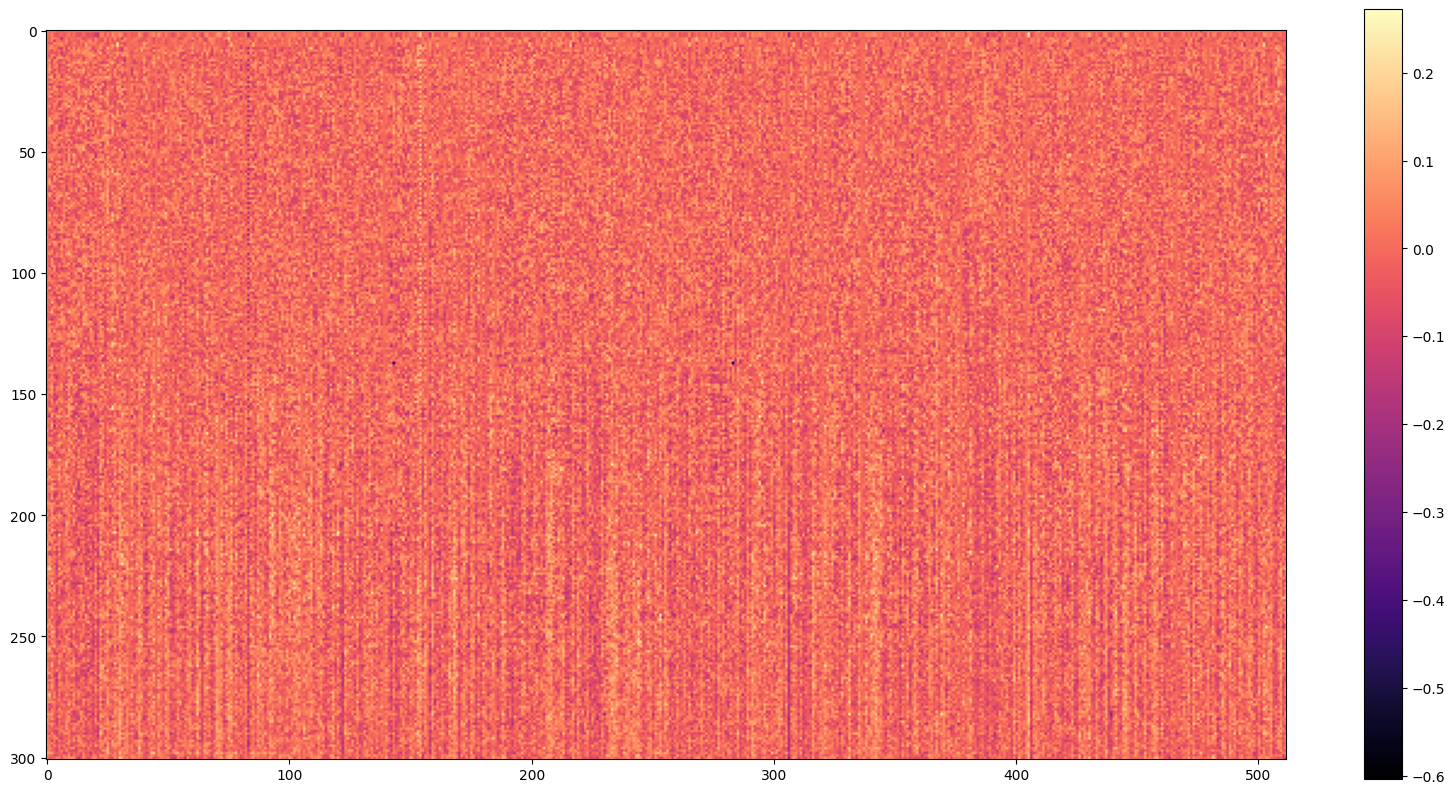

In [52]:
fig = plt.figure(figsize=(20,10))
plt.imshow(
    get_embedding(model),
    cmap="magma"
)
plt.colorbar()
plt.show()
plt.close()

### TSNE plot of the embedding
Dimentionality reduction helps vizualizing the embedding.\
Here we reduce the dimentionality of the embedding from 512 to 2.\
Note how similar tokens are close to each other and tend to form clusters.

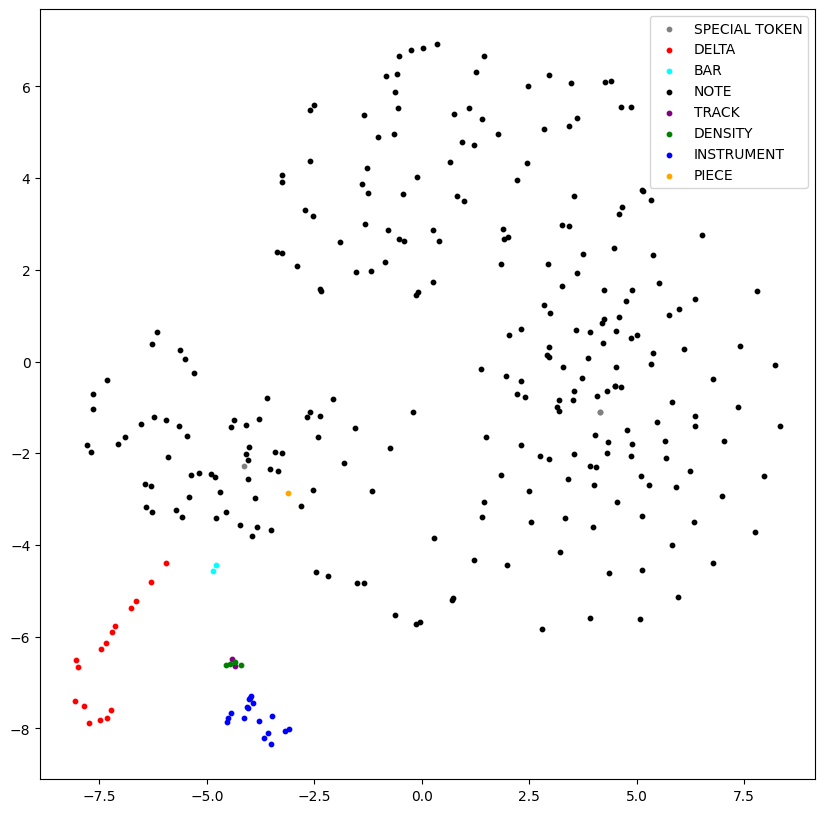

In [95]:
def plot_tsne(embedding, tokenizer):
    # make tsne plot of the embeddings
    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj = tsne.fit_transform(embedding)
    tsne_df = pd.DataFrame(
        {
            'X':tsne_obj[:,0], 
            'Y':tsne_obj[:,1], 
            'token':[tokenizer.decode(id) for id in range(len(tsne_obj[:,1]))]
            }
    )
    
    # plot the TSNE plot show the token only when hovering
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    to_plot = []
    for i, txt in enumerate(tsne_df['token']):
        label, color = assign_plot_token_label_and_color(txt)
        ax.scatter(tsne_df['X'][i], tsne_df['Y'][i], s=10, label=label, color=color)

        # ax.annotate(txt, (tsne_df['X'][i], tsne_df['Y'][i]), color = "white", hovercolor='black')
    # show only unique entry in the legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), [k.split("_")[-1] for k in by_label.keys()])
    plt.show()


embedding = get_embedding(model)
plot_tsne(embedding, tokenizer)

## Show the prediction given a sequence

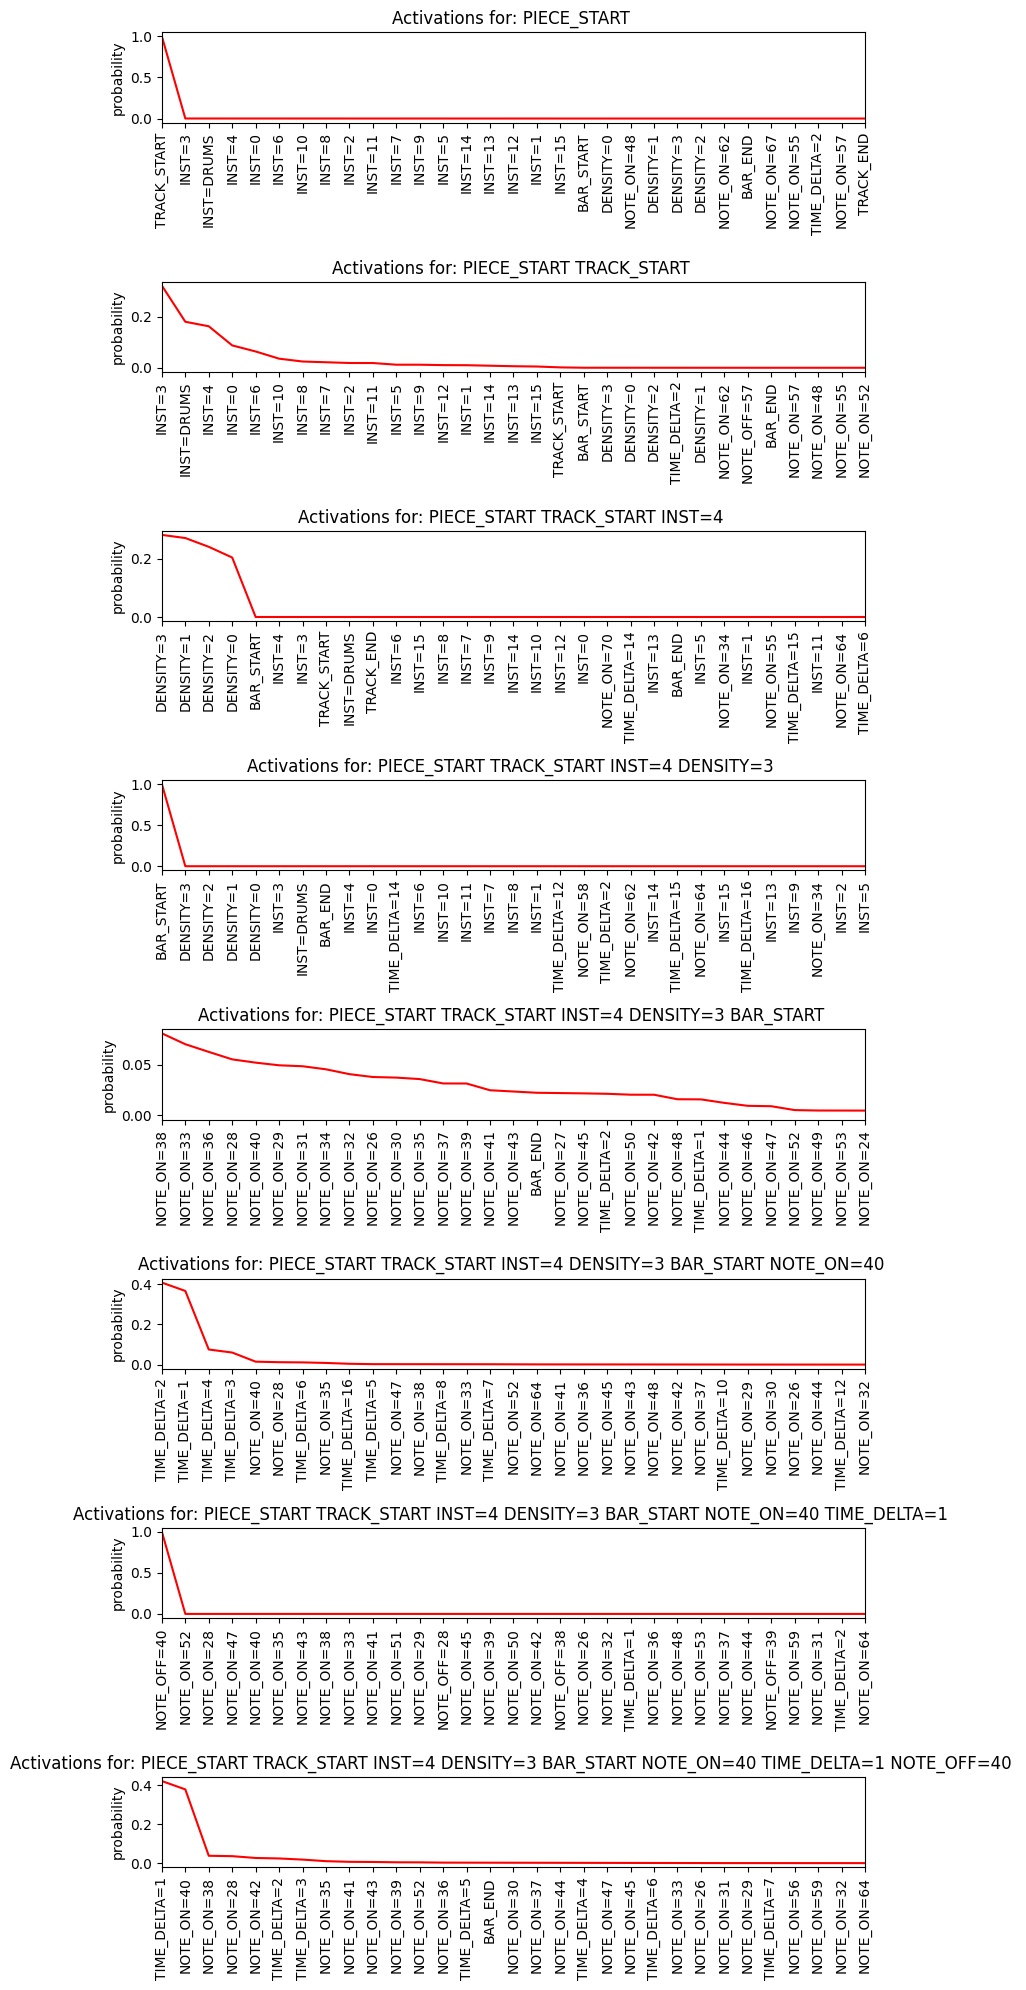

In [133]:
token_sequence = "PIECE_START TRACK_START INST=4 DENSITY=3 BAR_START NOTE_ON=40 TIME_DELTA=1 NOTE_OFF=40"
token_sequence_list = token_sequence.split(" ")
inputs = data_collator([tokenizer.encode(token_sequence)])
# inputs = [random.choice(data_tokenized)]
# inputs = data_collator(inputs)
outputs = model(**inputs)

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
summary_k_tokens = {}
fig = plt.figure(figsize=(8,20))
whole_seq=""
for p, token in enumerate(token_sequence_list):
    whole_seq += token + " "
    logits = outputs["logits"].detach().numpy()[0][p]
    activation = activations.detach().numpy()[0][p]
    order = activation.argsort()[::-1]
    # plt.subplot(len(token_sequence_list),1,p*2+1)
    # plt.plot(logits, label=token, color="black")
    # plt.tight_layout()
    # if p == 0:
    #     plt.title("Logits")
    # if p == len(token):
    #     plt.xlabel("token_ids")

    plt.subplot(len(token_sequence_list),1,p+1)
    plt.plot([activation[id] for id in order], label=token, color="red")
    plt.title(f"Activations for: {whole_seq}")
    plt.tight_layout()
    plt.xticks(ticks=range(len(order)), labels=[tokenizer.decode(id) for id in order], rotation=90)
    plt.xlim([0,30])
    plt.ylabel("probability")

    # summarizing things into a pandas dataframe
    sorted_arg_tokens = logits.argsort()[::-1]
    sorted_logits = logits[sorted_arg_tokens]
    summary_k_tokens[token] = pd.DataFrame.from_dict(
        {
            "token_ids": sorted_arg_tokens, 
            "tokens": [tokenizer.decode(id) for id in sorted_arg_tokens],
            "logits": logits[sorted_arg_tokens], 
            "softmax_activations": activation[sorted_arg_tokens]
        }
    )
    
plt.tight_layout()
plt.show()

# summary_k_tokens

## Show the embedding of past key values in each attention head ## TO IMPROVE

In [ ]:
# ploting the embedding of past key values in each attention head
for l, layer in enumerate(outputs["past_key_values"]):
    plt.figure()
    for b, block in enumerate(layer):
        for mh, multihead in enumerate(block):
            # print(multihead)
            for h, head in enumerate(multihead):
                # print(l, b, mh, h)
                plt.subplot(len(layer),len(multihead), len(multihead)*b+h+1)
                plt.imshow(head.detach().numpy().T)
                # plt.title(f"{b}, {mh}, {h}")
                if h == 0:
                    plt.text(
                        0, 0, f"Layer #{l} ; Block #{b} ; {mh}th head",
                        verticalalignment='bottom', 
                        horizontalalignment='right', 
                        color='black',
                        fontweight='bold'
                    )
                # hide axes
                plt.axis('off')
                plt.tight_layout()